# Standard libraries

In [1]:
import numpy as np
import h5py
import os,sys
from numpy import random
import matplotlib
from matplotlib.ticker import NullFormatter
from scipy import stats as ss
from scipy.spatial import distance

from mpl_toolkits.mplot3d import Axes3D

import matplotlib.cm as cm
import scipy.interpolate as si
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import seaborn as sns
from matplotlib import rc
sns.set(style='whitegrid', rc={"grid.linewidth": 0.1,'grid.color': '.9'})
sns.set_context("paper")                                                  
# plt.figure(figsize=(3.1, 3)) # Two column paper. Each column is about 3.15 inch wide.                                                                                                                                                                                                                                 
color = sns.color_palette("Set2", 6)
rc('font',size=12)
rc('font',family='serif')
rc('axes',labelsize=12)
rc('text', usetex=True)

%matplotlib inline


# Custom libraries

In [2]:
import fractionalPolarization

np.random.seed(seed=100)

#                         DEFINITIONS

In [3]:
def addToDict(key,dictionary,toAdd):  #different from the ray-tracing one!
    try:
        dk = dictionary[key]  #if the key is already there
        toAdd = np.array(toAdd)
        if key == 'pos':
            dictionary[key] = np.vstack((dictionary[key],toAdd))
        else:
            dictionary[key] = np.append(dictionary[key],toAdd)
        #print 'Adding ',key,'to dictionary',len(toAdd)
    except KeyError:
        dictionary[key] = []
        dk = dictionary[key]
        toAdd = np.array(toAdd)
        dictionary[key] = toAdd
        #print 'Adding ',key,'to dictionary',len(toAdd)

def vec_length(vector):
    return np.linalg.norm(vector,axis=1)
def unit_vector(vector):
    len = vec_length(vector)
    vector = vector/len[:, None]
    return vector
def angle_between(v1, v2_u):
    v1_u = unit_vector(v1)
    angle = np.arccos(np.dot(v1_u, v2_u))
    angle[np.isnan(angle)] = 0.
    return angle

def vec_length_scalar(vector):
    return np.linalg.norm(vector)
def unit_vector_scalar(vector):
    len = vec_length_scalar(vector)
    if(len > 0):
        return vector / len
    return vector
def angle_between_scalar(v1, v2_u):
    v1_u = unit_vector_scalar(v1)
    angle = np.arccos(np.dot(v1_u, v2_u))
    if np.isnan(angle):
        if (v1_u == v2_u).all():
            return 0.0
        else:
            return np.pi
    return angle

def rotationMatrix(angle,axis):
    "defines anticlockwise rotation about an axis"
    if axis == 0:
        return np.matrix([[1,0,0],[0,np.cos(angle),-np.sin(angle)],[0,np.sin(angle),np.cos(angle)]])
    if axis == 1:
        return np.matrix([[np.cos(angle),0,-np.sin(angle)],[0,1,0],[np.sin(angle),0,np.cos(angle)]])
    if axis == 2:
        return np.matrix([[np.cos(angle),-np.sin(angle),0],[np.sin(angle),np.cos(angle),0],[0,0,1]])

def scatterHist(x,y,z):
    #nullfmt = NullFormatter()         # no labels

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

    # start with a rectangular Figure
    plt.figure(1, figsize=(6, 6))

    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)

    # the scatter plot:
    axScatter.scatter(x, y, c = z,alpha = 0.3,lw = 0)
    axScatter.set_xlabel(r'SFR (M$_\odot$\,yr$^{-1}$)')
    axScatter.set_ylabel('Mass')    
    #cb = plt.colorbar(axScatter)
    #cb.set_label('Redshift')

    # now determine nice limits by hand:
    #binwidth = 0.25
    #xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
    #lim = (int(xymax/binwidth) + 1) * binwidth

    #axScatter.set_xlim((-lim, lim))
    #axScatter.set_ylim((-lim, lim))

    bins = 30   #np.arange(-lim, lim + binwidth, binwidth)
    axHistx.hist(x, bins=bins)
    axHisty.hist(y, bins=bins, orientation='horizontal')

    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())

    plt.savefig('exploreParameters.pdf',bbox_inches='tight')
    plt.clf()

def fraction(M,L):   #FROM Best(2005)
    M = 10**M/10**11
    # M given in units of 10^11M_star
    f0 = 0.0055   #pm 0.0004
    a = 2.5   #pm 0.2
    b = 0.35   #pm 0.03
    g = 1.54   #pm 0.11
    Ls = 2.5*10**24  #pm0.4*10**24
    num = f0*(M)**a
    dem = (L/Ls)**b + (L/Ls)**g
    return num/dem

def phi(lumList,author):
    if author == 'MS':  #Mauch & Sadler 2007
        C = 10**(-5.5)
        Ls = 10**(24.59)
        A = -1.27
        B = -0.49
    elif author == 'Prescott':  #Prescott 2015
        C = 10**(-6.4)
        Ls = 10**(26.26)
        A = -3.08
        B = -0.44
    else:
        sys.exit()
    lumList = np.array(lumList)
    return C/((Ls/lumList)**A + (Ls/lumList)**B)

def concatenate(l,desiredType):
    x = l[0]
    for i in range(1,len(l)):
        x = np.append(x,l[i])
    x = x.astype(desiredType)
    return x

def RMS(array):
    diff = array - np.mean(array)
    squared = np.multiply(diff,diff)
    summed = np.sum(squared)
    n = len(array)
    return np.sqrt((1.0/n)*summed)

def RMSerror(array):
    n = len(array)
    return RMS(array)/np.sqrt(1+n)

def magBinning(toBinx,toBiny):
    toBinx = np.array(toBinx)
    toBiny= np.array(toBiny)
    loc = np.where(toBinx>0)[0]
    toBinx = toBinx[loc]
    logToBin = np.log10(toBinx)
    lbRange = np.max(logToBin) - np.min(logToBin)
#     print np.max(logToBin),np.min(logToBin),lbRange,lbRange/0.4
    if (lbRange)%0.4 == 0:
        numBins = int(lbRange/0.4)
        maxEdge = np.max(logToBin)
    else:
        numBins = int(lbRange/0.4)+1
        maxEdge = np.max(logToBin)+(lbRange)%0.4
#     print np.min(logToBin),maxEdge,numBins,maxEdge%0.4
    binEdges = np.linspace(np.min(logToBin),maxEdge,numBins)
#     print binEdges
    binEdges = 10**binEdges 
    binMidpoints = binEdges[:-1] + np.diff(binEdges)/2
    statList = []

    for i in range(numBins-1):
#         print 'Num in bin',i,binEdges[i],binEdges[i+1],len(toBiny[(toBinx>=binEdges[i])&(toBinx<binEdges[i+1])])
        countVal = len(toBiny[(toBinx>=binEdges[i])&(toBinx<binEdges[i+1])])
        statList.append(float(countVal))
    return binEdges,binMidpoints,np.array(statList)

def binning(binNum,toBinx,toBiny,stat,scale):
    toBinx = np.array(toBinx)
    toBiny= np.array(toBiny)
    if scale == 'log':
        loc = np.where(toBinx>0)[0]
        toBinx = toBinx[loc]
        logToBin = np.log10(toBinx)
        binEdges = np.linspace(np.min(logToBin),np.max(logToBin),binNum+1)
        binEdges = 10**binEdges 
    elif scale == 'linear':
        binEdges = np.linspace(np.min(toBinx),np.max(toBinx),binNum+1)
    binMidpoints = binEdges[:-1] + np.diff(binEdges)/2
    statList = []
    if stat == 'count':
        for i in range(binNum):
#             print 'Num in bin',i,binEdges[i],binEdges[i+1],len(toBiny[(toBinx>=binEdges[i])&(toBinx<binEdges[i+1])])
            loc1 = np.where((toBinx>=binEdges[i])&(toBinx<binEdges[i+1]))[0]
            countVal = len(toBiny[loc1])
            statList.append(float(countVal))
    if stat == 'mean':
        for i in range(binNum):
            meanVal = np.mean(toBiny[loc1])
            statList.append(meanVal)
    statList = np.array(statList)
    return binEdges,binMidpoints,statList

def binnedStats(flux):
    global areaOnSky
    flux = flux[flux>0]
#    print np.min(flux),np.max(flux)
    bEdges, bMidpoints,binCounts = binning(20,flux,flux,'count','log')
    bwidths = np.diff(bEdges)
    averageFluxes = [np.mean(flux[(bEdges[i]<flux)&(flux<=bEdges[i+1])]) for i in range(len(bMidpoints))]
    S2p5 = np.array(averageFluxes)**(2.5)
    srInCone = areaOnSky * (np.pi/180)**2
    rmsAverage = S2p5*((binCounts/np.sqrt(binCounts))/bwidths)/srInCone   #0.7854 comes from angle of 1 degree on sky being thant many deg2
    S2p5dNdS = S2p5*(binCounts/bwidths)/srInCone   #needs to be flux^5/2*number/(bin width)*(solid angle)
    line = ss.linregress(averageFluxes,binCounts)
    return averageFluxes,S2p5dNdS,binCounts,rmsAverage,line

def replaceLine(file_name, parameter, newNumber):
        """
        Replacing some parameters in the params.txt file to reflect the lightcone being used
        """
        lines = open(file_name,'r').readlines()
        for i in range(len(lines)):
                words = content[i].split("=")
                if words[0] == parameter:
                        lines[i] = parameter+"="+str(newNumber)+"\n"
        out = open(file_name,'w')
        out.writelines(lines)
        out.close()

def plotbins(P1,P2,Llists):
    plt.figure()
    for i in range(len(P1)):
        e1,m1,s1 = binning(10,Llists[i],P1[i],'mean','log')
        e2,m2,s2 = binning(10,Llists[i],P2[i],'mean','log') 
#         s1 = np.array(s1)/5.39e6;s2 = np.array(s2)/5.39e6    #to get to Mpc^-3
#        print 'edges', e1[0],e2[0]
#        print 'midpoints',m1[0],m2[0]
#        print 'means',s1[0],s2[0]
        if i == 0:
            plt.plot(m1,s1,'g',marker = 'x',label = 'Prescott')
            plt.plot(m2,s2,'r',marker = 'x',label = 'MS')
        else:
            plt.plot(m1,s1,'g',marker = 'x')
            plt.plot(m2,s2,'r',marker = 'x') 
        plt.yscale('log')
        plt.xscale('log')
        plt.xlabel(r'L (W\,Hz$^{-1}$)')
        plt.ylabel('phi')
        plt.legend()
    plt.savefig('compareLmethods.pdf',bbox_inches='tight')
    
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

def sigmoid(x, x0, k, A):
    y = A/(1.0 + np.exp(-k*(x-x0)))
    return y

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    # Number of data points: n
    n =len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.linspace(0,1,n)

    return x, y

In [4]:
uv = unit_vector_scalar(np.array([18,2,3]))
print  (uv[2]+uv[1])/uv[0]

0.277777777778


# PARAMETERS

In [5]:
with open("params.txt") as f:
    content = f.readlines()
    for i in range(len(content)):
        line = content[i].split("=")
        if(line[0] == "NUMCUBES"):
            numCubes = int(line[1])
        if(line[0] == "LIGHTCONE_PATH"):
            datPath = line[1][:-1]
        if(line[0] == "SOURCES"):
            numSources = int(line[1])
        if line[0] == 'OPENINGANGLE':
            openingAngle = float(line[1])
        if(line[0] == "LOS"):
            print line[1]
            coneVec = unit_vector_scalar(np.array((line[1]).split(","), np.float))

datPath = '../../RomeelData/'
figurePath = '../../Thesis/Figures/'

areaOnSky = np.pi*openingAngle**2
seeingLimit = 10.0e-6 #Jy
confusionLimit = 2.0e-6

18,2,3



# IMPORT DATA

In [6]:
galaxyPositions = {}
galaxyAttributes = {}
coneAngle = 1.0
coneAngleAtRedshift = 2.0 #cone angle +z. Therefore, sources will have to be normalised back to an angle of 1 in the RM map

lengths = []
for cube in range(numCubes):

    with h5py.File(os.path.expanduser(datPath+'GALAXY_positions_'+str(cube)),'r') as data:
        names =  data.keys()
        for name in names:
            dat = data[name][:]
            addToDict(name,galaxyPositions,dat)

    with h5py.File(os.path.expanduser(datPath+'GALAXY_'+str(cube)),'r') as data:
        names =  data.keys()
        for name in names:
            dat = data[name][:]
            addToDict(name,galaxyAttributes,dat)
    lengths.append(len(dat))

galaxySFR = galaxyAttributes['sfr']  #M_star/yr
galaxyMass = galaxyAttributes['masses_stellar']   #M_star
galaxyZ =  galaxyAttributes['redshift']
galaxyDist =  galaxyAttributes['distance']   #comoving distance
galaxyDistL =  galaxyAttributes['distance']*(1.0+galaxyZ)  #luminosity distance
galPos = np.asarray(galaxyPositions['pos'])

print galaxyAttributes.keys()

numGalaxies = len(galaxySFR)
print 'Total number of galaxies is',numGalaxies
print 'Mass range is',np.min(galaxyMass),np.max(galaxyMass)
print 'Redshift range is',np.min(galaxyZ),np.max(galaxyZ)
print 'Distance range is',np.min(galaxyDist),np.max(galaxyDist)
print np.where(np.isinf(galaxySFR))[0]
print len(galaxySFR),len(galaxyMass),len(galaxyDist),len(galaxyZ)

galaxySFR[galaxySFR==1] = 0.0

[u'distance', u'central', u'redshift', u'radii_stellar', u'sfr', u'masses_gas', u'masses_stellar', u'radii_gas', u'radii_r200']
Total number of galaxies is 613568
Mass range is 349445900.236 1.17299469799e+12
Redshift range is 0.016093840101 1.04449021741
Distance range is 48.0719243297 2387.46548733
[]
613568 613568 613568 613568


# Check method for L from star forming galaxies

In [7]:
def SFRFromL(L):   #
    sfr= np.zeros(len(L))
    Lc = 6.4e21
    smaller = np.where(L<=Lc)[0]
    equalover = np.where(L>Lc)[0]
    factor = 1.0/(0.1+0.9*(L[smaller]/Lc)**0.3)
    sfr[smaller] = L[smaller]*5.52e-22*factor
    sfr[equalover] = L[equalover]*5.52e-22
    return sfr

def SFRFromLuLc(L):
    sfr= np.zeros(len(L))
    Lc = 6.4e21
    sfr = L*(5.52e-22/(0.1+0.9*(L/Lc)**0.3))
    return sfr

def SFRFromLoLc(L):
    sfr= np.zeros(len(L))
    Lc = 6.4e21
    sfr = L*5.52e-22
    return sfr

def assignLFromSFR(sfr):
    inverse = LfromSFR_function()
    sfr = sfr.reshape((len(sfr),1))
    L = np.apply_along_axis(applyLfromSFRvalue,1,sfr,inverse)
    L = L.reshape(len(sfr))
    return L
    
def LfromSFR_function():
    logL_test = np.linspace(14,24,10000)
    luminosity_test = 10**logL_test
    sfl = SFRFromL(luminosity_test)
    inverse = si.interp1d(sfl,luminosity_test)
    return inverse

def applyLfromSFRvalue(sfrValue,inverse):
    if sfrValue > 0.0:
        return inverse(sfrValue)
    else:
        return 0.0
    
def SFRLumFunction(L):
    C = 1.0*10**(-2.83)
    Lstar = 10**(21.18)
    alpha = 1.02
    omega = 0.60
    factor = C*(L/Lstar)**(1-alpha)
    exponent = np.exp(-0.5*(np.log10(1+L/Lstar)/omega)**2)
    return factor*exponent

780
1.39223657243e-05 306.833659964


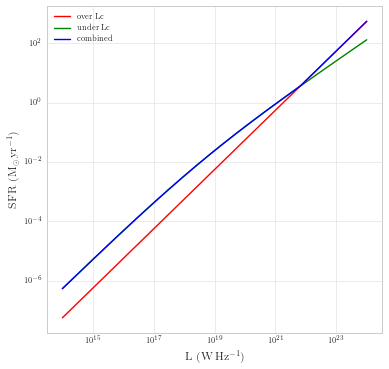

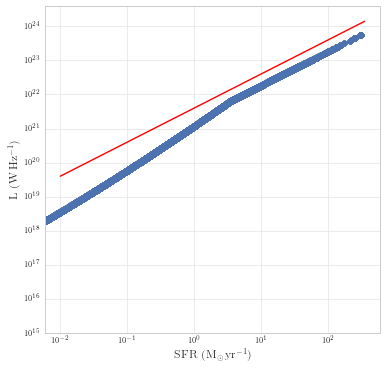

In [8]:
plt.figure(figsize=(6,6))
logL = np.linspace(14,24,1000)
luminosity = 10**logL
sfl = SFRFromL(luminosity)
plt.plot(luminosity,SFRFromLoLc(luminosity),'r',label = 'over Lc')
plt.plot(luminosity,SFRFromLuLc(luminosity),'g',label = 'under Lc')
plt.plot(luminosity,sfl,'b',label = 'combined')
print np.argmin(abs(luminosity - 6.4e21))
print min(galaxySFR[galaxySFR>0]),max(galaxySFR)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'SFR (M$_\odot$\,yr$^{-1}$)')
plt.xlabel(r'L (W\,Hz$^{-1}$)')
plt.legend(loc = 'best')

SFRrange = np.linspace(0.01,350,1000)
plt.figure(figsize=(6,6))
plt.scatter(galaxySFR[galaxySFR>0],assignLFromSFR(galaxySFR)[galaxySFR>0])
condon = SFRrange*4.0e21
plt.plot(SFRrange, condon,'r')
# plt.xlim(1e-5,1e3)
# plt.ylim(10e14,10e24)
plt.xlabel(r'SFR (M$_\odot$\,yr$^{-1}$)')
plt.ylabel(r'L (W\,Hz$^{-1}$)')
plt.xscale('log')
plt.yscale('log')


# SFG flux

In [10]:
#Checking flux for star forming galaxies
#threshold for luminosity relation is >5M_star and no galaxies are smaller than that

print 'SFR from galaxies ranges from',np.min(galaxySFR), 'to',np.max(galaxySFR),'with',np.sum(galaxySFR>0),'elements greater than 0'
print 'There are ',len(galaxySFR[galaxySFR>0]),'spirals with SFR > 0'
print 'There are ',len(galaxySFR[galaxySFR<=0]),'ellipticals with SFR = 0'
print 'There are ',len(galaxySFR[galaxySFR>1.0e-11]),'spirals with SFR > 10^-11'
galaxyLum = assignLFromSFR(galaxySFR)    #luminosity relation without threshold (W/Hz)
galaxyL = galaxyLum
#-----------RATIO TESTING-----------------
ratioForSFR = 4.58177042932
ratioForSFR2 = 2*4.58177042932
ratioForSFR10 = 10.0
galaxyLum_over0 = galaxyLum[galaxyLum>0]
positiveSFRindices = np.where(galaxyLum>0)[0]
numberToKeep = int(len(galaxyLum_over0)*(1-(1/ratioForSFR)))
# numberToKeep = int(len(galaxyLum_over0)*(9/10.0))
excludePercentindices = random.choice(positiveSFRindices,numberToKeep,replace=False)
galaxyLum_keepPercent = galaxyLum[:]
print 'length of original Luminosity file:',len(galaxyLum)
print 'length of array elements over 0:',len(galaxyLum_over0)
print 'length of elements over 0 to set to 0:',len(excludePercentindices)
print 'length of elements kept',len(galaxyLum_over0)-len(excludePercentindices)
print 'number of elements in lum array that are 0 before setting new ones to 0:',len(galaxyLum[galaxyLum==0])
print 'number of elements in lum array that are supposed to be excluded that are above 0:',np.sum(np.count_nonzero(galaxyLum_keepPercent[excludePercentindices]))
galaxyLum_keepPercent[excludePercentindices] = 0.0
print 'number of elements in lum array that are 0 after setting new ones to 0:',np.sum(galaxyLum_keepPercent==0)
galaxyL = galaxyLum_keepPercent
#-----------------------------------------
print len(galaxyL[galaxyL>0]),len(galaxyLum_keepPercent[galaxyLum_keepPercent>0])



print 'Luminosity from SFR ranges from', np.min(galaxyL[galaxyL>0.0]),'to',np.max(galaxyL),'if we ignore the ones that are 0.0, of which there are',(len(galaxyL)-np.count_nonzero(galaxyL))
alpha = -0.7
galaxyF_sfr = (galaxyL*(1+galaxyZ)**alpha)/(4.0*np.pi*(galaxyDistL*3.085677581e+22)**2)  #distance must be changed from Mpc to m (W/m^2)
SFR_Flux = galaxyF_sfr*10e26
print 'Flux from SFR ranges from', np.min(SFR_Flux[SFR_Flux>0]),'to',np.max(SFR_Flux),'if we ignore the ones that are 0.0, of which there are',(len(galaxySFR)-np.count_nonzero(SFR_Flux))
print 'There are',len(SFR_Flux[SFR_Flux>seeingLimit]),'sources with flux from SFR over seeingLimit (without the application of fractional polarization)'
sfrLcheck = assignLFromSFR(np.array([0,0.01,1,25,50,100,150,200,250]))  
print sfrLcheck
len(galaxySFR[(galaxySFR>0)&(galaxySFR<0.01)]),len(galaxyL[(galaxyL>0)&(galaxyL<sfrLcheck[1])]),len(galaxySFR)

SFR from galaxies ranges from 0.0 to 306.833659964 with 402641 elements greater than 0
There are  402641 spirals with SFR > 0
There are  210927 ellipticals with SFR = 0
There are  402641 spirals with SFR > 10^-11
length of original Luminosity file: 613568
length of array elements over 0: 402641
length of elements over 0 to set to 0: 314762
length of elements kept 87879
number of elements in lum array that are 0 before setting new ones to 0: 210927
number of elements in lum array that are supposed to be excluded that are above 0: 314762
number of elements in lum array that are 0 after setting new ones to 0: 525689
87879 87879
Luminosity from SFR ranges from 2.80300164175e+15 to 5.55858079644e+23 if we ignore the ones that are 0.0, of which there are 525689
Flux from SFR ranges from 8.06691968166e-12 to 0.0908264713832 if we ignore the ones that are 0.0, of which there are 525689
There are 33568 sources with flux from SFR over seeingLimit (without the application of fractional polarizati

(9910, 2155, 613568)

In [11]:
SFRTest_Lum = []
Ltest = []
Ptest = []
#bin width, dL, cancels out in the ratio, so it doesn’t matter that it is in weird magnitude units, as long as the bin width is the same for every bin
lmin = np.log10(np.min(galaxyL[galaxyL>0.0])); lmax = 24.0
L = np.linspace(10**lmin,10**lmax,100)
dL = L[1]- L[0]
PMS = SFRLumFunction(L)
# PP = phi(10**L,'Prescott')

sumPMS  = sum(PMS)
Lprobability = PMS/sumPMS
Prange = [np.min(Lprobability),np.max(Lprobability)]
print 'probability range',Prange
print 'dL',dL
print 'sum(p(L_i))dL',sum(Lprobability*dL)

probability range [6.7216108179428119e-06, 0.6273909386994474]
dL 1.01010100727e+22
sum(p(L_i))dL 1.01010100727e+22


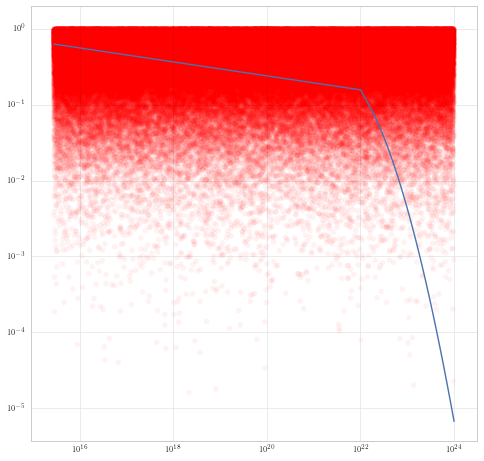

In [12]:
plt.figure(figsize = (8,8))
plt.plot(L,Lprobability,label = 'Probability')
plt.xscale('log')
plt.yscale('log')
# plt.title('Comparison of the sampled points and the probability curve.\n All points under the curve are selected for luminosities to attach to AGN')

testGal = galaxyL[galaxyL>0]

while len(SFRTest_Lum)<len(testGal):
    randomToL = lmin + (random.random() * (lmax-lmin))
    randomToL = 10**randomToL
    randomToP = random.random()
    randomToP = randomToP
    Ltest.append(randomToL),Ptest.append(randomToP)
    PFromLChoice = SFRLumFunction(randomToL)/sumPMS
    if randomToP<=PFromLChoice:
        SFRTest_Lum.append(randomToL)
plt.scatter(Ltest,Ptest,alpha = 0.05,c = 'r',edgecolor = 'none')
plt.savefig(figurePath+'LSamplingProcess.pdf',bbox_inches='tight')

In [13]:
# plt.figure(figsize = (8,8))

# plt.plot(L,PMS,label = 'Probability')
# plt.xscale('log')
# plt.yscale('log')
# plt.title('Comparison of the sampled points and the probability curve.\n All points under the curve are selected for luminosities to attach to AGN')

# plt.plot(al2,numDensity,label = 'Number counts from SFR-luminosity conversion')
# plt.plot(al2,numDensity*ratio,label = 'Number counts from SFR-luminosity conversion, shifted by %f'%ratio)
# plt.xlabel(r'L (W\,Hz$^{-1}$)')
# plt.legend(loc='best')
# plt.ylabel('Number density')

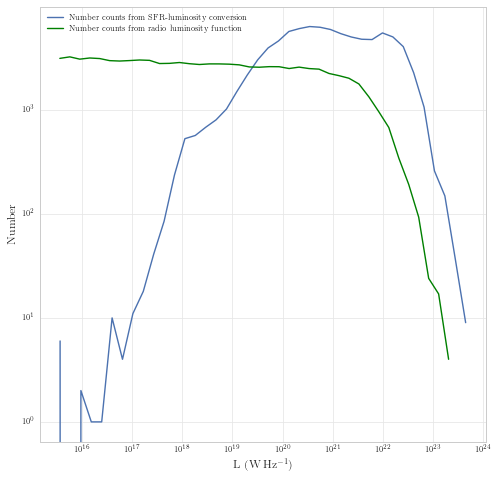

In [14]:
plt.figure(figsize = (8,8))
al1,al2,al3 = binning(40,galaxyL,galaxyL,'count','log')
plt.plot(al2,al3,label = 'Number counts from SFR-luminosity conversion')
al1,al2,al3 = binning(40,SFRTest_Lum,SFRTest_Lum,'count','log')
plt.plot(al2,al3,label = 'Number counts from radio luminosity function',c='g')
# plt.title('Comparison of resulting numbers and RLF for star forming galaxies')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.xlabel(r'L (W\,Hz$^{-1}$)')
plt.ylabel('Number')

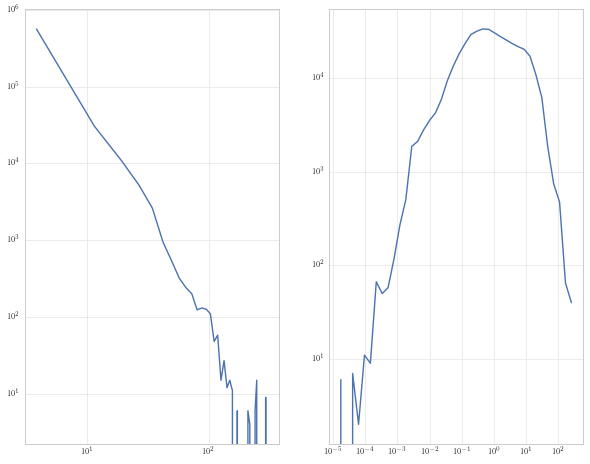

In [15]:
plt.figure(figsize = (10,8))
plt.subplot(1,2,1)
al1,al2,al3 = binning(40,galaxySFR,galaxySFR,'count','linear')
plt.plot(al2,al3)
# plt.title('Number counts from sfr with linear binning')
plt.xscale('log')
plt.yscale('log')
plt.subplot(1,2,2)
al1,al2,al3 = binning(40,galaxySFR,galaxySFR,'count','log')
plt.plot(al2,al3)
# plt.title('Number counts from sfr with log binning')
plt.xscale('log')
plt.yscale('log')



# AGN Flux

Mass bins: [  8.54337995   9.04708225   9.55078455  10.05448685  10.55818915
  11.06189145  11.56559375  12.06929605]
Minimum L for each mass bin: [1e+22 1e+22 1e+22 1e+22 1e+22 1e+22 1e+22]
Fraction per mass bin of galaxies that are AGN [1.1671089572908853e-07 2.1201527522113506e-06 3.85143791813864e-05
 0.0006996464769722046 0.012709673715218296 0.012709673715218296
 0.012709673715218296]


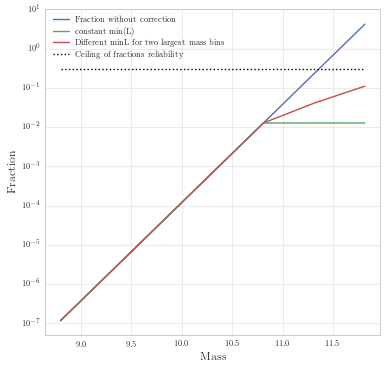

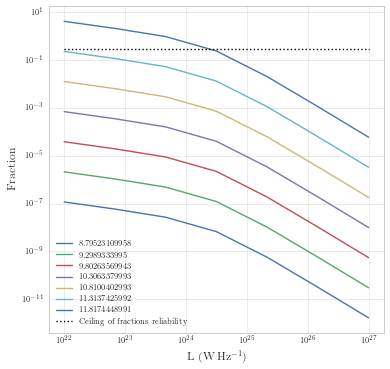

In [16]:
steps = 7 #7
Msteps = np.linspace(np.log10(np.min(galaxyMass)),np.log10(np.max(galaxyMass)),steps+1)  #np.linspace(smallestGal,biggestGal,steps)   #steps of 0.5 in log space
massMidpoints = Msteps[:-1] + np.diff(Msteps)/2
MstepsRound = np.round(Msteps,2);massMidpointsRound = np.round(massMidpoints,2)

#since we can't get fractions any higher than 30% without losing accuracy, we must either use a fraction from a smaller mass bin as the fraction for larger mass bins or egin from different minimum L
Lsteps = np.linspace(22,27,steps)
Lsteps = 10**Lsteps
minimumL =  np.zeros(len(massMidpoints))+10**22 #from Best 2005: "The host galaxies of radio-loud active galactic nuclei: mass dependences,gas cooling and active galactic nuclei feedback"
minimumL_differentForLargerMass = np.append(minimumL[:-2],[7.61871770232e+23,6.27766010581e+24])  #Last two entries are from testing where the last two mass bins reach a fraction of 30%

print 'Mass bins:',Msteps
print 'Minimum L for each mass bin:',minimumL
frac = fraction(massMidpoints,minimumL) #fraction of galaxies in the mass bin that are AGNs
frac[-2] = frac[-3]; frac[-1] = frac[-3]   #This is applying the same fraction across the last 3 mass bins
frac_differentForLargerMass = fraction(massMidpoints,minimumL_differentForLargerMass)
print 'Fraction per mass bin of galaxies that are AGN',frac
#---------------

plt.figure(figsize=(6,6))
plt.plot(massMidpoints,fraction(massMidpoints,np.zeros(len(massMidpoints))+10**22), label = 'Fraction without correction')
plt.plot(massMidpoints,frac,label = 'constant min(L)')
plt.plot(massMidpoints,frac_differentForLargerMass, label = 'Different minL for two largest mass bins')
plt.plot(massMidpoints,np.ones(len(massMidpoints))*0.3,'k:', label = "Ceiling of fractions reliability")
plt.yscale('log')
plt.legend(loc = 'best')
plt.ylabel('Fraction')
# plt.title('Fractions per mass bin of galaxies that are AGN')
plt.xlabel('Mass')
plt.savefig(figurePath+'AGNFractions.pdf',bbox_inches='tight')

plt.figure(figsize=(6,6))
# plt.plot(Msteps,frac,label = 'constant min(L)')
for i in massMidpoints:
    plt.plot(Lsteps,fraction(0*Lsteps+i,Lsteps),label = str(i))
plt.plot(Lsteps,np.ones(steps)*0.3,'k:', label = "Ceiling of fractions reliability")
plt.xscale('log')
plt.yscale('log')
plt.legend(loc = 'best')
plt.ylabel('Fraction')
plt.xlabel(r'L (W\,Hz$^{-1}$)')
# plt.title('Fractions per mass bin of galaxies that are AGN above a certain luminosity')
plt.savefig(figurePath+'AGNFractionsPerMassBin.pdf',bbox_inches='tight')

Repeats in IDs [] 0
425 425
Repeats in AGN IDs [] 0
Number of galaxies that will be selected from mass bin 8.8 is : 0 out of 283217 galaxies of this mass
Number of galaxies that will be selected from mass bin 9.3 is : 0 out of 148011 galaxies of this mass
Number of galaxies that will be selected from mass bin 9.8 is : 3 out of 89408 galaxies of this mass
Number of galaxies that will be selected from mass bin 10.31 is : 44 out of 63134 galaxies of this mass
Number of galaxies that will be selected from mass bin 10.81 is : 326 out of 25676 galaxies of this mass
Number of galaxies that will be selected from mass bin 11.31 is : 48 out of 3799 galaxies of this mass
Number of galaxies that will be selected from mass bin 11.82 is : 4 out of 322 galaxies of this mass
The total number of AGN chosen are 425 in total
Total % of galaxies that are selected as AGN: 0.0692669761135


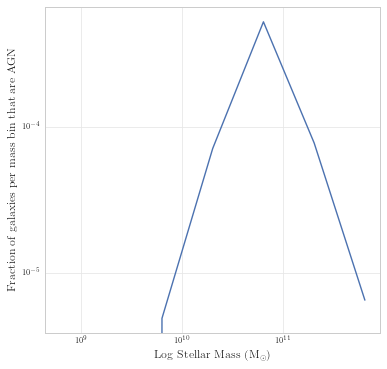

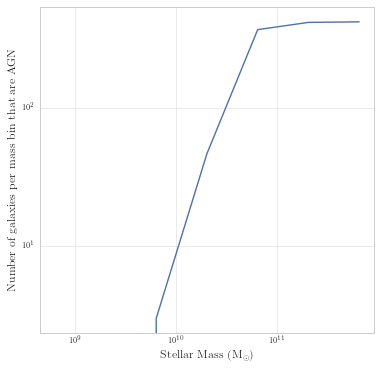

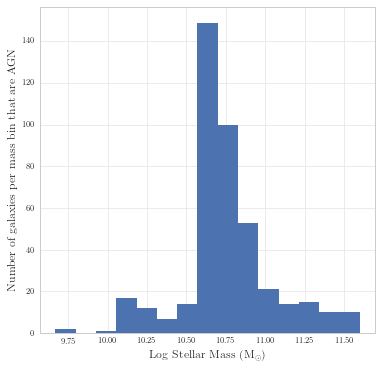

In [26]:
#Checking flux for AGNs
logGM = np.log10(galaxyMass)
numberToChoose = []
numberPerMass = []
IDsInBin = []

for i in range(steps):
#     galaxiesInMassBin = np.where((galaxyMass>10**smallestGal)&(galaxyMass<=10**(smallestGal+0.5)))[0]
    galaxiesInMassBin = np.where((galaxyMass>10**Msteps[i])&(galaxyMass<=10**Msteps[i+1]))[0]
    numberInMassBin = len(galaxiesInMassBin)   #Number of galaxies that are found in each mass bin
    IDsInBin.append(galaxiesInMassBin)
    numberPerMass.append(numberInMassBin)
    numberChosen = int(frac[i]*numberInMassBin)
    numberToChoose.append(numberChosen)

IDs = np.array(concatenate(IDsInBin,int))
uniqueIDs = np.unique(IDs,return_index=True,return_counts=True)
setIDs = uniqueIDs[0]
countIDs = uniqueIDs[2]
uniqueIDs_index = uniqueIDs[1]
print "Repeats in IDs",countIDs[countIDs>1],len(countIDs[countIDs>1])    
    
AGN_IDs = []
for i in range(steps):
    numberChosen = numberToChoose[i]
    if numberChosen>0:
        galaxiesChosen = random.choice(IDsInBin[i],numberChosen) #this list can contain duplicates
        uniqueGalaxiesChosen = np.unique(galaxiesChosen)
        while len(uniqueGalaxiesChosen)<numberChosen:
            newChoice = random.choice(IDsInBin[i],1)
            while np.any(uniqueGalaxiesChosen == newChoice):
                newChoice = random.choice(IDsInBin[i],1)
            uniqueGalaxiesChosen = np.append(uniqueGalaxiesChosen,newChoice)
        AGN_IDs.append(uniqueGalaxiesChosen)
    else:
        AGN_IDs.append([])   
numberToChoose = np.array(numberToChoose)

# plt.figure(figsize=(6,6))
# plt.plot(10**massMidpoints,numberToChoose)
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel(r'Stellar Mass (M$_\odot$)')
# plt.ylabel('Number of galaxies per mass bin that are AGN')
# # plt.title('Number of AGN taken from each mass bin')
# plt.savefig(figurePath+'NumberAGNPerMassBin.pdf',bbox_inches='tight')

plt.figure(figsize=(6,6))
plt.plot(10**massMidpoints,numberToChoose/float(numGalaxies))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Log Stellar Mass (M$_\odot$)')
# plt.title('Fraction of all galaxies that are AGN')
plt.ylabel('Fraction of galaxies per mass bin that are AGN')
plt.savefig(figurePath+'FractionTotalAGNPerMassBin.pdf',bbox_inches='tight')

plt.figure(figsize=(6,6))
plt.plot(10**massMidpoints,np.cumsum(numberToChoose))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Stellar Mass (M$_\odot$)')
plt.ylabel('Number of galaxies per mass bin that are AGN')
# plt.title('Number of AGN taken from each mass bin')
plt.savefig(figurePath+'cumulativeNumberAGNPerMassBin.pdf',bbox_inches='tight')

#----------------------
#Check that there are no repeats in AGN IDs
AGNs = np.array(concatenate(AGN_IDs,int))
uniqueAGNs = np.unique(AGNs,return_index=True,return_counts=True)
setAGNs = uniqueAGNs[0]
print len(AGNs),len(setAGNs)
countAGNs = uniqueAGNs[2]
uniqueAGNs_index = uniqueAGNs[1]
print "Repeats in AGN IDs",countAGNs[countAGNs>1],len(countAGNs[countAGNs>1]) 


plt.figure(figsize=(6,6))
plt.hist(logGM[AGNs],bins = 15)
plt.xlabel(r'Log Stellar Mass (M$_\odot$)')
plt.ylabel('Number of galaxies per mass bin that are AGN')
# plt.title('Number of AGN taken from each mass bin')
plt.savefig(figurePath+'NumberAGNPerMassBin.pdf',bbox_inches='tight')

#---------------------
for i in range(steps):
    print 'Number of galaxies that will be selected from mass bin',massMidpointsRound[i],'is :',numberToChoose[i],'out of',numberPerMass[i],'galaxies of this mass'
print 'The total number of AGN chosen are',sum(numberToChoose),'in total'
print 'Total % of galaxies that are selected as AGN:',float(sum(numberToChoose))/len(galaxySFR)*100.0

[ 0.          0.          0.0033554   0.06969303  1.26966817  1.26349039
  1.24223602]


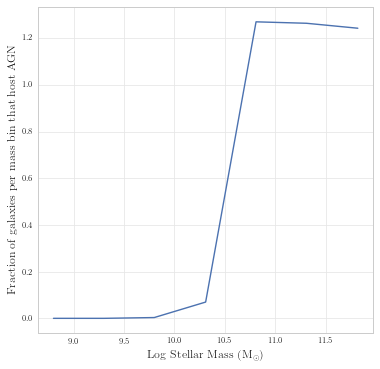

In [32]:
print (numberToChoose*100.0/numberPerMass)
plt.figure(figsize=(6,6))
plt.plot(massMidpointsRound,numberToChoose*100.0/numberPerMass, label = 'Fraction of bin')
plt.xlabel(r'Log Stellar Mass (M$_\odot$)')
plt.ylabel('Fraction of galaxies per mass bin that host AGN')
# plt.title('Number of AGN taken from each mass bin')
plt.savefig(figurePath+'FractionInBin_AGNPerMassBin.pdf',bbox_inches='tight')


probability range [4.4696785751625237e-05, 0.95860721852294062]
dL 1.01009090909e+25
sum(p(L_i))dL 1.01009090909e+25
13025791.3308


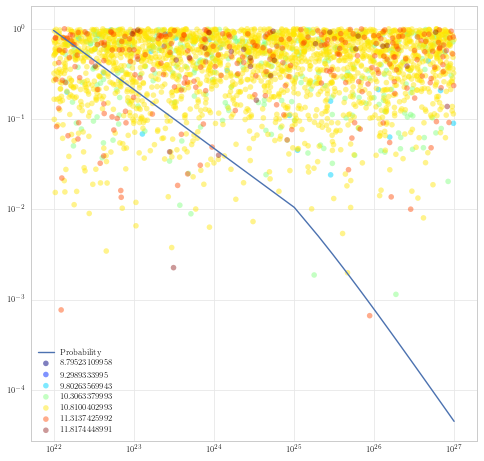

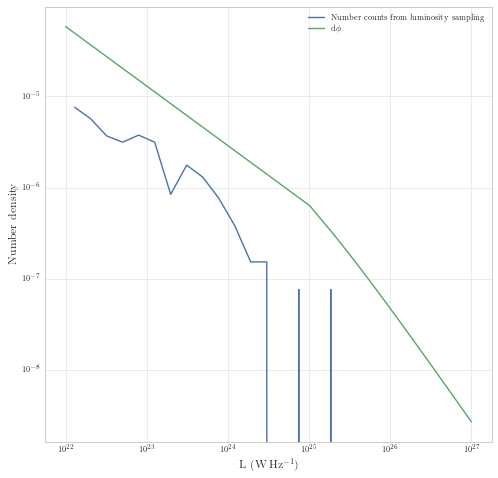

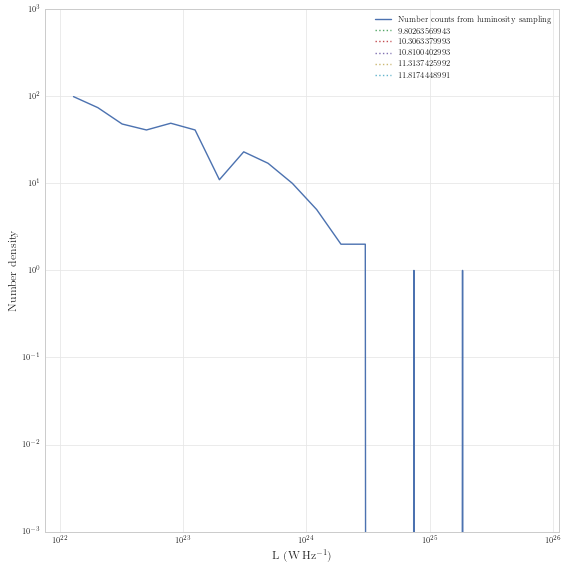

In [33]:
AGN_Lum = []
#bin width, dL, cancels out in the ratio, so it doesn’t matter that it is in weird magnitude units, as long as the bin width is the same for every bin
L = np.linspace(10**22.0,10**27.0,100)
dL = L[1]- L[0]
PMS = phi(L,'MS')
# PP = phi(10**L,'Prescott')

plt.figure(figsize = (8,8))
sumPMS  = sum(PMS)
Lprobability = PMS/sumPMS
Prange = [np.min(Lprobability),np.max(Lprobability)]
print 'probability range',Prange
print 'dL',dL
print 'sum(p(L_i))dL',sum(Lprobability*dL)

plt.plot(L,Lprobability,label = 'Probability')
plt.xscale('log')
plt.yscale('log')
# plt.title('Comparison of the sampled points and the probability curve.\n All points under the curve are selected for luminosities to attach to AGN')
plt.savefig(figurePath+'LSamplingProcess.pdf',bbox_inches='tight')

colors = cm.jet(np.linspace(0, 1, steps))
for i in range(steps):
    testedLum = []
    testedP = []
    sampledLum = []
    while len(sampledLum)<numberToChoose[i]:
        randomToL = 22 + (random.random() * 5)
        randomToL = 10**randomToL
        randomToP = random.random()
        randomToP = randomToP
        testedLum.append(randomToL),testedP.append(randomToP)
        PFromLChoice = phi(randomToL,'MS')/sumPMS
        if randomToP<=PFromLChoice:
            sampledLum.append(randomToL)
    plt.scatter(testedLum,testedP,alpha = 0.05*(10 - i/3),c = colors[i],label = str(massMidpoints[i]),edgecolor = 'none')
    AGN_Lum.append(sampledLum)
plt.legend()          
    
AL = concatenate(AGN_Lum,float)


volumeInCone = np.pi*(np.max(galaxyDist)*np.tan(np.radians(1.0)))**2*np.max(galaxyDist)
print volumeInCone
plt.figure(figsize = (8,8))
al1,al2,al3 = binning(20,AL,AL,'count','log')
plt.plot(al2,al3/volumeInCone,label = 'Number counts from luminosity sampling')
plt.plot(L,PMS,label = r'd$\phi$$')
# plt.title('Comparison of resulting numbers and RLF (Scaled up by factor of $10^6$).')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'L (W\,Hz$^{-1}$)')
plt.ylabel('Number density')

plt.figure(figsize = (8,8))
al1,al2,al3 = binning(20,AL,AL,'count','log')
plt.plot(al2,al3,label = 'Number counts from luminosity sampling')
# plt.title('Comparison of resulting numbers')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel(r'L (W\,Hz$^{-1}$)')
plt.ylabel('Number density')
for i in range(steps):
    if len(AGN_Lum[i])<2:
        pass
    else:
        epts,xpts,curve = binning(20,np.log10(AGN_Lum[i]),np.log10(AGN_Lum[i]),'count','linear')
        curve[curve==0] = np.nan
        plt.plot(10**xpts,curve/volumeInCone,'x:',label = str(massMidpoints[i]))
        plt.xscale('log')
        plt.yscale('log')
        plt.legend()

plt.ylim(0.001,1000)
plt.tight_layout()
plt.savefig(figurePath+'NumberAGNSampledPerMassBin.pdf',bbox_inches='tight')

In [23]:
AGN_Flux = []
AGN_Dist = []
for i in range(steps):
    if len(AGN_Lum[i])>0:
        AGN_Dist = galaxyDistL[AGN_IDs[i]]
        AGN_Flux.append(((np.array(AGN_Lum[i])*(1+galaxyZ[i])**alpha)/(4.0*np.pi*(AGN_Dist*3.085677581e+22)**2))*10e26)
    else:
        AGN_Flux.append([])

print 'Flux from AGN range from', np.min(concatenate(AGN_Flux,float)),'to',np.max(concatenate(AGN_Flux,float))

Flux from AGN range from 3.79004217529e-05 to 0.38667676597


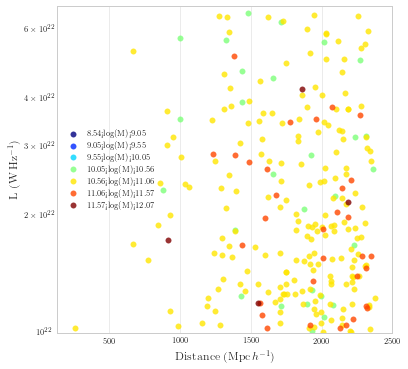

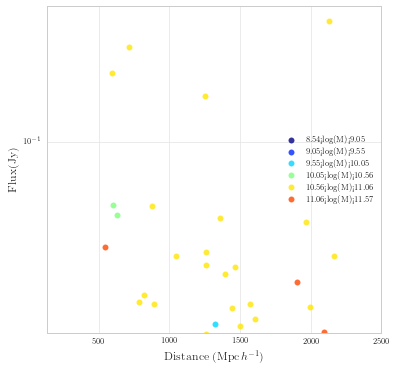

In [24]:
plt.figure(figsize=(6,6))
for i in range(steps):
        plt.scatter(galaxyDist[AGN_IDs[i]],AGN_Lum[i],label=str(MstepsRound[i])+'<log(M)<'+str(MstepsRound[i+1]),alpha = 0.8,color = colors[i])
plt.legend()
plt.yscale('log')
plt.ylabel(r'L (W\,Hz$^{-1}$)')
plt.xlabel(r'Distance (Mpc\,$h^{-1$)')
# plt.title('Luminosity vs distance')
plt.ylim(Lsteps[0],Lsteps[1])
plt.savefig(figurePath+'AGN_LvsDist.pdf',bbox_inches='tight')

plt.figure(figsize=(6,6))
for i in range(steps-1):
    plt.scatter(galaxyDist[AGN_IDs[i]],AGN_Flux[i],label=str(MstepsRound[i])+'<log(M)<'+str(MstepsRound[i+1]),alpha = 0.8,color = colors[i])
    plt.legend()
plt.yscale('log')
plt.ylabel(r'Flux(Jy)')
plt.xlabel(r'Distance (Mpc$\,h^{-1$)')
# plt.title('Flux vs distance')
plt.savefig(figurePath+'AGN_FluxvsDist.pdf',bbox_inches='tight')


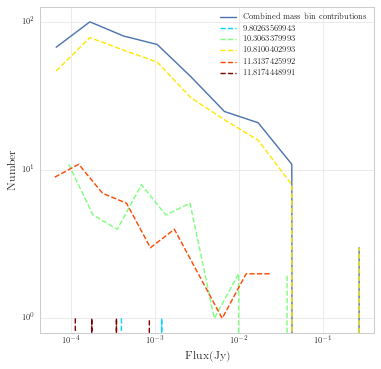

In [25]:
AF = concatenate(AGN_Flux,float)
plt.figure(figsize=(6,6))
epts,xpts,curve = binning(10,AF,AF,'count','log')
plt.plot(xpts,curve,label = 'Combined mass bin contributions')

for i in range(steps):
    if len(AGN_Flux[i])<2:
        pass
    else:
        epts,xpts,curve = binning(10,AGN_Flux[i],AGN_Flux[i],'count','log')
        plt.plot(xpts,curve,'--',label = str(massMidpoints[i]),c = colors[i])

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Flux(Jy)')
plt.ylabel(r'Number')
plt.legend()
# plt.title('Number vs flux for AGNs')
plt.savefig(figurePath+'AGN_NvsFlux.pdf',bbox_inches='tight')

fractionOfWhole [ 0.          0.          0.00048894  0.00717117  0.05313185  0.00782309
  0.00065192]
2
2
2
2
2


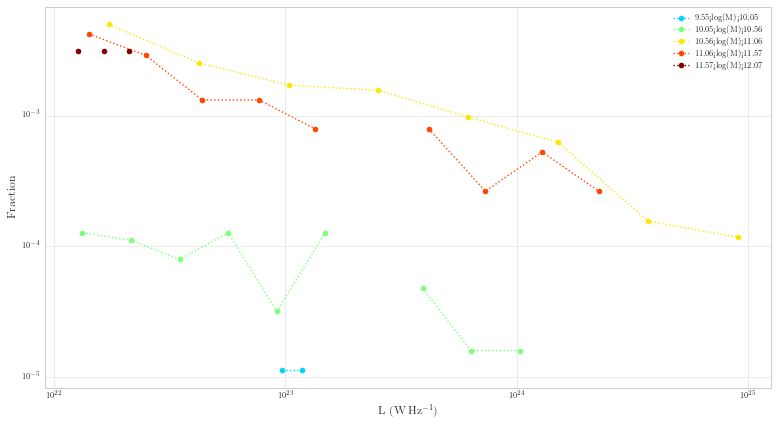

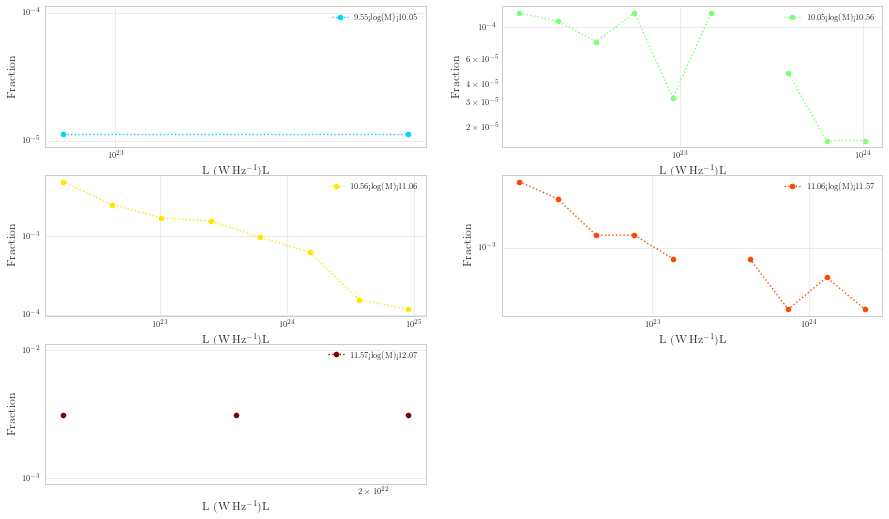

In [26]:
fractionOfWhole = 100*np.array(numberToChoose)/float(len(galaxyMass))
print 'fractionOfWhole',fractionOfWhole
plt.figure()
smallestGal = 9
plt.figure(figsize = (13,7))
for i in range(steps):
    if len(AGN_Lum[i])==1:
        plt.scatter(AGN_Lum[i],1.0/numberPerMass[i],label = str(MstepsRound[i])+'<log(M)<'+str(MstepsRound[i+1]),c = colors[i])
    elif numberToChoose[i]>1 :
        epts,xpts,curve = binning(10,AGN_Lum[i],AGN_Lum[i],'count','log')
        frac = curve/numberPerMass[i]
        frac[frac==0] = np.nan
        plt.plot(xpts,frac,'o:',label = str(MstepsRound[i])+'<log(M)<'+str(MstepsRound[i+1]),c = colors[i])
        plt.xscale('log')
        plt.yscale('log')
        plt.ylabel('Fraction')
        plt.xlabel(r'L (W\,Hz$^{-1}$)')
#         plt.title('Fraction of galaxies that are AGN per mass bin')
        plt.legend(loc = 'best')

plt.savefig(figurePath+'FractionAGNPerL.pdf',bbox_inches='tight')
# plt.savefig('reproduceBest2005.pdf')

p=0
plt.figure(figsize = (15,15))
for i in range(steps):
    if len(AGN_Lum[i])==0:
        p +=1
        pass
    else:
        print p
        plt.subplot(5,2,i-p+1)
        if len(AGN_Lum[i])==1:
            plt.scatter(AGN_Lum[i],1.0/numberPerMass[i],label = str(MstepsRound[i])+'<log(M)<'+str(MstepsRound[i+1]),c = colors[i])
            plt.legend(loc = 'best')
            plt.xscale('log')
            plt.yscale('log')
            plt.ylabel('Fraction')
#             plt.title('Fraction of galaxies in that are AGN in mass bin')
            plt.xlabel(r'L (W\,Hz$^{-1}$)')
            plt.ylim(10e-6,10e-4)
        elif len(AGN_Lum[i])>1:
            epts,xpts,curve = binning(10,AGN_Lum[i],AGN_Lum[i],'count','log')
            frac = curve/numberPerMass[i]
            frac[frac==0] = np.nan
            plt.plot(xpts,frac,'o:',label = str(MstepsRound[i])+'<log(M)<'+str(MstepsRound[i+1]),c = colors[i])
            plt.xscale('log')
            plt.yscale('log')
            plt.ylabel('Fraction')
#             plt.title('Fraction of galaxies in that are AGN in mass bin')
            plt.xlabel(r'L (W\,Hz$^{-1}$)''L')
            plt.legend(loc = 'best')

        

plt.legend()
plt.savefig(figurePath+'FractionAGNPerL_massbins.pdf',bbox_inches='tight')

# Combining fluxes 

AGN flux(>0) ranges from 3.79004217529e-05 to 0.38667676597 and the number of fluxes = 0 are 613143
Flux from SFR ranges from 8.06691968166e-12 to 0.102011016767 if we ignore the ones that are 0.0, of which there are 525689
16239
415


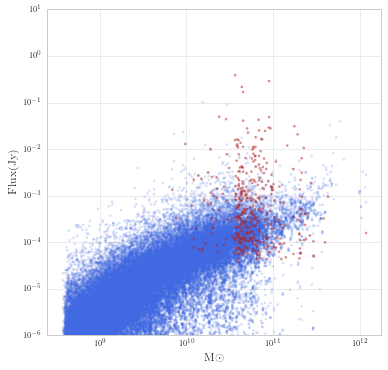

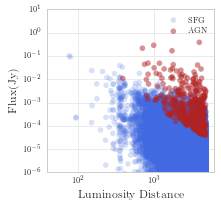

In [49]:
AGNFluxes = np.zeros(len(galaxySFR))
#Add SFR fluxes
for subset in range(len(AGN_IDs)):
    for n in range(len(AGN_IDs[subset])):
        if len(AGN_IDs[subset])>0:
            AGNFluxes[AGN_IDs[subset][n]] = AGN_Flux[subset][n]
#---------------------
print 'AGN flux(>0) ranges from', np.min(AGNFluxes[AGNFluxes>0]),'to',np.max(AGNFluxes), 'and the number of fluxes = 0 are',len(AGNFluxes[AGNFluxes==0])
print 'Flux from SFR ranges from', np.min(SFR_Flux[SFR_Flux>0]),'to',np.max(SFR_Flux),'if we ignore the ones that are 0.0, of which there are',(len(galaxySFR)-np.count_nonzero(SFR_Flux))
finalFluxesBeforeFP = np.add(AGNFluxes,SFR_Flux)

plt.figure(figsize=(6,6))
plt.scatter(galaxyMass[galaxySFR>0],SFR_Flux[galaxySFR>0],c='royalblue',s = 7,alpha = 0.2,label = 'SFG',edgecolor='none')
plt.scatter(galaxyMass[AGNs],AGNFluxes[AGNs],c='firebrick',s = 7,alpha = 0.5,label = 'AGN',edgecolor='none')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'Flux(Jy)')
plt.ylim(1.0e-6,10)
# plt.legend()
plt.xlabel('M$\odot$')
# plt.title('Flux vs mass for AGN and SFG')
plt.savefig(figurePath+'combinedSources_FluxvsMass.pdf',bbox_inches='tight')

plt.figure(figsize=(3,3))
plt.scatter(galaxyDistL[galaxySFR>0],SFR_Flux[galaxySFR>0],c='royalblue',alpha = 0.2,label = 'SFG',edgecolor='none')
plt.scatter(galaxyDistL[AGNs],AGNFluxes[AGNs],c='firebrick',alpha = 0.5,label = 'AGN',edgecolor='none')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'Flux(Jy)')
plt.ylim(1.0e-6,10)
plt.legend()
plt.xlabel('Luminosity Distance')
# plt.title('Flux vs mass for AGN and SFG')

# plt.figure(figsize=(6,6))
# x_sfr, y_sfr = ecdf(SFR_Flux)
# x_agn, y_agn = ecdf(AGNFluxes)
# print y_sfr
# # Generate plot
# plt.plot(x_sfr, y_sfr,marker = '.', linestyle = 'none',label = 'SFG')
# plt.plot(x_agn, y_agn,marker = '.', linestyle = 'none',label = 'AGN')
# # Make the margins nice
# plt.margins(0.02)
# plt.xscale('log')
# # Label the axes
# plt.xlabel(r'Flux(Jy)')
# plt.ylabel('ECDF')

print sum(SFR_Flux>5.0e-5)
print sum(AGNFluxes>5.0e-5)
# print len(finalFluxes[galaxySFR>5e-5])

/Users/lauren/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:207: RuntimeWarning: invalid value encountered in divide


1e-05
Number of sources that have total I> 10uJy: 33796
Number of sources that have total I> 0.5uJy: 68931


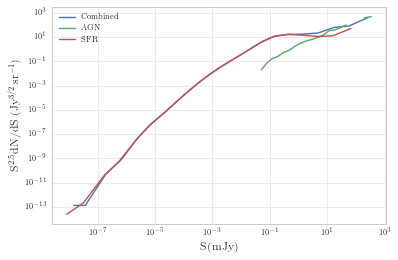

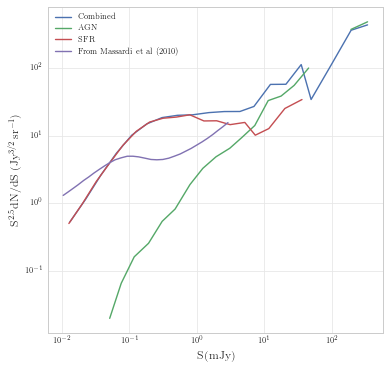

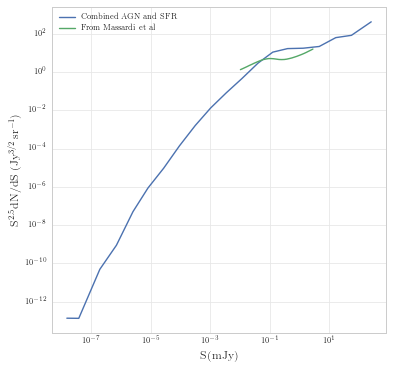

In [52]:
massardiDNDS_x_apparently = np.array([0.000010519086393080612,0.00001617302317216139,0.00002304821850951948 ,0.000045639477032622,0.00009269001811442897,0.0002030917620904743,0.00035436477855785574,0.0006341584770237443,0.0010788648231414449,0.0019306977288832555,0.0032025395772304803,0.005179474679231218,0.008167476848278902,0.013209279232530555,0.0213633979115266,0.03455107294592225,0.07196856730011529,0.13209279232530555,0.23638851566381916,0.49238826317067313,1]
)
massardiDNDS_y_apparently = np.array([1.6468790945648186,2.3325709781700557,3.006228432773891,4.83876114618303,8.291286432319982,14.221819191514143,18.960237707018255,24.51135891886915,26.27319683542297,25.66935223545904,22.820799656761917,20.922415407315164,21.051586129945086,22.549314982202716,26.51688001611186,32.16807016840147,47.19474826196091,67.00486339318334,98.10338476689634,168.15904246438805,297.2497329513397]
)


massardiDNDS_x = np.array([0.000010430632318756327,0.000012222874510005365,0.000014706215311826546,0.000017384931543697918,0.000020915283071370623,0.00002494491138068798,0.00002974838399225966,
0.00003611079915462652,0.00004269194780812009,0.00005092147719638817,0.00006128285318378432,0.00007508958143290422,
0.00009283320603967116,0.00011280250234700135,0.00013709061638829886,0.0001696143696171896,0.00020800386377916794,0.00025501736031048426,
0.00031260396283422153,0.0003830970400421487,0.0004611659092090257,0.0005650164560620188,0.000818415542092559,0.0009848612405152055,
0.0011851579218414374,0.0014260691871325927,0.0017158059258782464,0.002028165649407523,0.002418715770030595,0.0028842270409422974
])
massardiDNDS_y = np.array([1.3170953754750694, 1.4704969052079189, 1.67834169075317, 1.8945756957163313, 2.1863159274807815, 2.46799626213407
, 2.8168308309203334, 3.2149708051674097, 3.589417066799179, 4.00747492285807, 4.425201127301099, 4.727604619332695
, 4.9953347108232995, 4.9953347108232995, 4.886469758144123, 4.675805735358166,4.474223796917946, 4.425201127301099
, 4.474223796917946, 4.675805735358166, 4.9953347108232995, 5.395819536866989, 6.507244562619144, 7.265140527360106, 8.111308307897005,
9.156352169090992, 10.450540579975423, 11.927653763950351, 13.613546899696694, 15.709857612767502])

fig = plt.figure()
fluxList = [finalFluxesBeforeFP[finalFluxesBeforeFP>0],AGNFluxes[AGNFluxes>0],SFR_Flux[SFR_Flux>0]]
fluxlabels = ['Combined','AGN','SFR']
for i in range(3):
    midp,binVal,counts,rmsAve,fitline = binnedStats(fluxList[i])
    midp = np.array(midp)*1000 #if midp*1000, then use mJy for xlabel
    #plt.errorbar(midp,binVal,yerr=rmsAve,fmt='o')
    plt.plot(midp,binVal,label = fluxlabels[i])
plt.ylabel(r'S$^{2.5}$dN/dS (Jy$^{3/2}$\,sr$^{-1}$)')
plt.xlabel('S(mJy)')
plt.xscale('log') 
plt.yscale('log')
plt.legend(loc='best') 
# plt.title('Source populations before fractional polarisation')
plt.savefig('sourceCountsVflux_BFP.pdf',bbox_inches='tight')

fig = plt.figure(figsize = (6,6))
fluxList = [finalFluxesBeforeFP[finalFluxesBeforeFP>seeingLimit],AGNFluxes[AGNFluxes>seeingLimit],SFR_Flux[SFR_Flux>seeingLimit]]
fluxlabels = ['Combined','AGN','SFR']
for i in range(3):
    midp,binVal,counts,rmsAve,fitline = binnedStats(fluxList[i])
    #plt.errorbar(midp,binVal,yerr=rmsAve,fmt='o')
    midp = np.array(midp)*1000 #if midp*1000, then use mJy for xlabel
    plt.plot(midp,binVal,label = fluxlabels[i])  
plt.plot(massardiDNDS_x*1000,massardiDNDS_y,label = 'From Massardi et al (2010)')
plt.ylabel(r'S$^{2.5}$dN/dS (Jy$^{3/2}$\,sr$^{-1}$)')
plt.xlabel('S(mJy)')
plt.xscale('log') 
plt.yscale('log')
plt.legend(loc='best') 
plt.savefig('sourceCountsVflux_BFP.pdf',bbox_inches='tight')
# plt.title('Source populations before fractional polarisation, cropped to the seeing limit')

fig = plt.figure(figsize = (6,6))
midp,binVal,counts,rmsAve,fitline = binnedStats(finalFluxesBeforeFP[finalFluxesBeforeFP>0])
midp = np.array(midp)*1000 #if midp*1000, then use mJy for xlabel
plt.plot(midp,binVal,label = 'Combined AGN and SFR')  
plt.plot(massardiDNDS_x*1000,massardiDNDS_y,label = 'From Massardi et al')
plt.ylabel(r'S$^{2.5}$dN/dS (Jy$^{3/2}$\,sr$^{-1}$)')
plt.xlabel('S(mJy)')
plt.xscale('log') 
plt.yscale('log')
plt.legend(loc='best') 
plt.savefig('combinedVmassardi.pdf',bbox_inches='tight')
print seeingLimit
print 'Number of sources that have total I> 10uJy:',len(np.where(finalFluxesBeforeFP>seeingLimit)[0])
print 'Number of sources that have total I> 0.5uJy:',len(np.where(finalFluxesBeforeFP>0.5e-6)[0])

In [29]:
#We need to find the ratio by which we are off  with our source counts
# ratio = 9.0/10
# SFR_Flux_over0 = SFR_Flux[SFR_Flux>0]
# ninetyPercent = random.choice(np.where(SFR_Flux_over0>0)[0],int(len(SFR_Flux_over0)*ratio))
# SFR_Flux_tenPercent = SFR_Flux
# print sum(finalFluxesBeforeFP>0)
# SFR_Flux_tenPercent[ninetyPercent] = 0 
# finalFluxes_tenPercent = np.add(AGNFluxes,SFR_Flux_tenPercent)
# print sum(finalFluxesBeforeFP>0),sum(finalFluxes_tenPercent>0)

# fig = plt.figure(figsize = (10,10))
# midp,binVal,counts,rmsAve,fitline = binnedStats(finalFluxesBeforeFP[finalFluxesBeforeFP>0])
# midp = np.array(midp)*1000 #if midp*1000, then use mJy for xlabel
# plt.plot(midp,binVal,label = 'Combined AGN and SFR')  
# plt.plot(massardiDNDS_x*1000,massardiDNDS_y,label = 'From Massardi et al')
# shiftedSourceCounts_x,shiftedSourceCounts_y,counts,rmsAve,fitline = binnedStats(finalFluxesBeforeFP[finalFluxes_tenPercent>0])
# shiftedSourceCounts_x = np.array(shiftedSourceCounts_x)*1000 #if midp*1000, then use mJy for xlabel
# plt.plot(shiftedSourceCounts_x,shiftedSourceCounts_y,label = 'Shifted')
# plt.ylabel(r'S$^{2.5}$dN/dS (Jy$^{3/2}$\,sr$^{-1}$)')
# plt.xlabel('S(mJy)')
# plt.xscale('log') 
# plt.yscale('log')
# plt.legend(loc='best') 
# print 'Number of sources that have total I> 10uJy:',len(np.where(finalFluxesBeforeFP>seeingLimit)[0])
# print 'Number of sources that have total I> 10uJy after shift:',len(np.where(finalFluxes_tenPercent>seeingLimit)[0])

In [30]:
#fractional polarisation options
percentBG = [fractionalPolarization.percent_pol(40,0.0,0.0) for i in range(len(finalFluxesBeforeFP))]
percentT = [fractionalPolarization.percent_pol(20,0.0,0.0) for i in range(len(finalFluxesBeforeFP))]
p = [percentBG,percentT]

Total flux(>0) ranges from 6.38027999209e-15 to 0.0183301953365 and the number of fluxes = 0 are 525345
Number of sources with polarized flux density> 10uJy: 2736
Number of sources with 0 flux: 525345
Number of sources with flux <= 2.0e-6: 85487


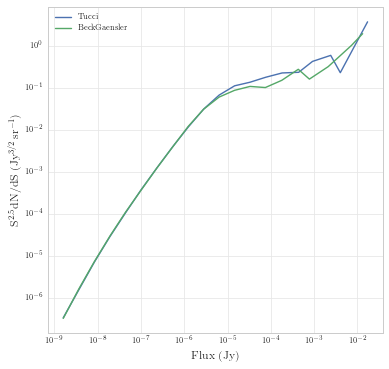

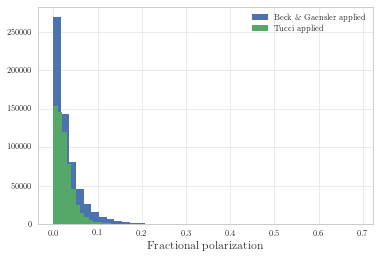

In [31]:
# Source count plot
fig = plt.figure(figsize = (6,6))
pollabels = ['Tucci','Beck&Gaensler']
for i in range(2):
    ffbfp = finalFluxesBeforeFP*p[i]
    midp,binVal,counts,rmsAve,fitline = binnedStats(ffbfp[ffbfp>1e-9])
    #plt.errorbar(midp,binVal,yerr=rmsAve,fmt='o')
    plt.plot(midp,binVal,label = pollabels[i])
#     plt.xlim(1.0e-6,1)
    
plt.ylabel(r'S$^{2.5}$dN/dS (Jy$^{3/2}$\,sr$^{-1}$)')
plt.xlabel('Flux (Jy)')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
# box_x = [seeingLimit,seeingLimit,max(midp),max(midp),seeingLimit]
# box_y = [binVal[find_nearest(midp, seeingLimit)],max(binVal),max(binVal),binVal[find_nearest(midp, seeingLimit)],binVal[find_nearest(midp, seeingLimit)]]
# plt.plot(box_x,box_y)
plt.savefig('sourceCountsVflux.pdf',bbox_inches='tight')

fig = plt.figure()
plt.hist(percentBG,bins=40,label = 'Beck \& Gaensler applied')
plt.hist(percentT,bins=20, label = 'Tucci applied')
plt.xlabel('Fractional polarization')
# plt.title('Histogram of fractional polarization')
plt.legend()
finalFluxes = finalFluxesBeforeFP*percentBG

#---------------------
print 'Total flux(>0) ranges from', np.min(finalFluxes[finalFluxes>0]),'to',np.max(finalFluxes), 'and the number of fluxes = 0 are',len(finalFluxes[finalFluxes==0])
print 'Number of sources with polarized flux density> 10uJy:',len(np.where(finalFluxes>seeingLimit)[0])
print 'Number of sources with 0 flux:', (len(finalFluxes)-np.count_nonzero(finalFluxes)) 
print 'Number of sources with flux <= 2.0e-6:', len(np.where((finalFluxes>0)&(finalFluxes<=seeingLimit))[0])

sourceFluxes = finalFluxes[finalFluxes>seeingLimit]

# Transform for angular projection 

[ 0.98052248  0.10894694  0.16342041]
LOS theta 0.165148677415
[[ 0.98639392  0.16439899  0.        ]
 [-0.16439899  0.98639392  0.        ]
 [ 0.          0.          1.        ]]
LOS phi 0.110657221174
[[ 0.99388373  0.          0.11043153]
 [ 0.          1.          0.        ]
 [-0.11043153  0.          0.99388373]]
Unit vector tests
[[ 0.99257211  0.10894694  0.0541403 ]]
[[ 0.98509218 -0.0537323   0.16342041]]
[[ 0.99711386 -0.0537323   0.05363566]]
--------


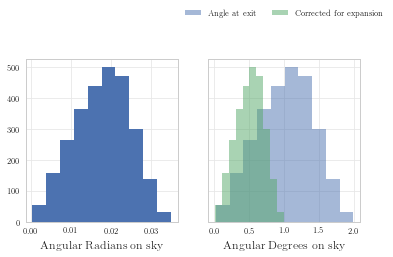

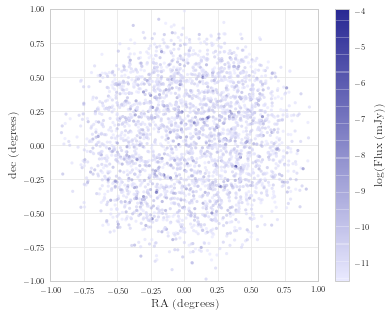

In [32]:
sourcePos = galaxyPositions['pos'][finalFluxes>seeingLimit]
sourceRadii = galaxyAttributes['radii_r200'][finalFluxes>seeingLimit]
sourceDist = galaxyDist[finalFluxes>seeingLimit]

print coneVec
LOStheta =  np.arctan(coneVec[2]/coneVec[0])#angle between x and y
print "LOS theta",LOStheta
rotY = rotationMatrix(-LOStheta,2)
print rotY
LOSphi = np.arctan(coneVec[1]/coneVec[0])	#angle between x and z
print "LOS phi",LOSphi
rotZ = rotationMatrix(-LOSphi,1)
print rotZ

print 'Unit vector tests'
print rotZ.dot(coneVec.T)
print rotY.dot(coneVec.T)
print (rotZ*rotY).dot(coneVec.T)
print '--------'

transformToProjection = rotY*rotZ #rotation matrix

sourceA = np.array(transformToProjection.dot(sourcePos.T))
sourceA = sourceA.T

cubeDistances = np.apply_along_axis(np.linalg.norm,1,sourcePos)

centralRayDistance = np.mean(cubeDistances)
centralRay = centralRayDistance * coneVec
centralRayVec = np.array(transformToProjection.dot(centralRay.T))
transformedConeVec = np.array(transformToProjection.dot(coneVec.T))

#In testing, angle_between(sourcePos, coneVec) and angle_between(sourceA, unit_vector_scalar(testVec[0])) is preserved.
#Since the angles between sources are between 0 and 2, but the positions map to much smaller values, all I need to do is map them so that they lie 
#In a way that the projection maintains the angles

#Find angles between cone central vector and individual sources
A = angle_between(sourceA, transformedConeVec[0])
#Find angular projections

dists = sourceA - transformedConeVec[0]*cubeDistances[:,np.newaxis]   #Vector between source and central ray
yzDists = dists[:,1:]
unitDistances = np.apply_along_axis(unit_vector_scalar,1,yzDists)    #Distance between source and central ray, normalised
angleDist = unitDistances*(np.degrees(A)/2.0)[:,np.newaxis]
XY = np.array(angleDist)
distDifference = np.apply_along_axis(np.linalg.norm,1,XY)

fig,(ax1, ax2) = plt.subplots(1,2, sharey=True,figsize = (6,3))

ax1.hist(A)
ax1.set_xlabel('Angular Radians on sky')
ax2.hist(np.degrees(A),alpha = 0.5, label= 'Angle at exit')
ax2.set_xlabel('Angular Degrees on sky')
ax2.hist(distDifference,alpha = 0.5, label = 'Corrected for expansion')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),ncol=2)
plt.savefig('angleHistSources.pdf',bbox_inches='tight')

# plt.figure(figsize=(5,6))
# numSources = len(sourceFluxes)
# numPlots = 21
# chunks = numSources/numPlots
# for i in range(numPlots):
#     plt.subplot(numPlots/3,3,i+1)
#     plt.scatter(XY[chunks*i:chunks*(i+1),0],XY[chunks*i:chunks*(i+1),1],alpha = 0.4,edgecolors= 'none', c = 14+np.log10(sourceFluxes[chunks*i:chunks*(i+1)]),norm = matplotlib.colors.LogNorm(vmin = -14, vmax = 1))
#     plt.xlim(-1,1)
#     plt.ylim(-1,1)
#     distRange = [np.min(galaxyDist[chunks*i:chunks*(i+1)]),np.max(galaxyDist[chunks*i:chunks*(i+1)])]
#     plt.title('Distance range:'+str(np.round(distRange[0],2))+' to '+str(np.round(distRange[1],2)))
#     cb = plt.colorbar(label = 'log(Flux)')
# plt.savefig(figurePath+'sourceProjection.pdf')

plt.figure(figsize=(6,5))
cmap = sns.light_palette("navy", as_cmap=True)
plt.scatter(XY[:,0],XY[:,1],alpha = 0.6,edgecolors= 'none',s=10,c = np.log(sourceFluxes), cmap =cmap)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("RA (degrees)")
plt.ylabel("dec (degrees)")
cb = plt.colorbar(label = 'log(Flux (mJy))')
plt.savefig(figurePath+'sourceProjection2.pdf',bbox_inches='tight')

np.random.seed(seed=120)
rm = random.normal(0, 6, size=(len(sourceRadii),1))

In [33]:
# replaceLine('params.txt', 'SOURCES', len(sourceFluxes))

# with h5py.File('sourceData','w') as hf:
#     hf.create_dataset('intrinsicRM', data =rm, chunks = True, compression = 'gzip',compression_opts=4)
#     hf.create_dataset('sourcePositions', data =sourcePos, chunks = True, compression = 'gzip',compression_opts=4)
#     hf.create_dataset('sourceRadii', data =sourceRadii, chunks = True, compression = 'gzip',compression_opts=4)
#     hf.create_dataset('sourceProjection', data 
#                     =XY, chunks = True, compression = 'gzip',compression_opts=4)


/Users/lauren/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:207: RuntimeWarning: invalid value encountered in divide


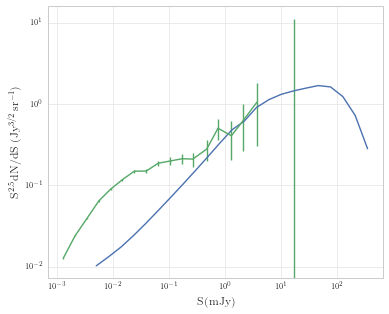

In [34]:
stiletal2014_S = np.array([0.0050,0.0083,0.0138,0.0229,0.0380,0.0631,0.1047,
                  0.1738,0.2884,0.4786,0.7943,1.318,2.188,3.630,6.026,
                  10.0,16.6,27.54,45.71,75.86,125.89,208.93,346.74])  #in mJy already
stiletal2014_counts = np.array([0.0103,0.0133,0.0175,0.0241,0.0340,0.0489,0.0706,
                       0.1027,0.1503,0.2217,0.3295,0.4828,0.6184,0.9115,
                      1.135,1.320,1.454,1.572,1.690,1.626,1.235,0.724, 0.283])

plt.figure(figsize=(6,5))
plt.plot(stiletal2014_S,stiletal2014_counts)
midp,binVal,counts,rmsAve,fitline = binnedStats(finalFluxes[finalFluxes>1.0e-6])
plt.errorbar(np.array(midp)*1e3,binVal,yerr=rmsAve,label= 'Final source counts (polarised flux density)')
# plt.plot(litDNDS_x,litDNDS_y,'cyan',label = 'From literature')
# plt.plot(massardiDNDS_x,massardiDNDS_y,label = 'From Massardi et al')
plt.ylabel(r'S$^{2.5}$dN/dS (Jy$^{3/2}$\,sr$^{-1}$)')
plt.xlabel('S(mJy)')
plt.xscale('log')
plt.yscale('log')
# plt.legend(loc='upper left')
plt.savefig(figurePath+'finalSouceCounts.pdf',bbox_inches='tight')

In [35]:
- in source count plot, need to divide by bin width
- for s^5/2, use average flux in the bin, rather than midpoint
- plot at that value too
- convert D_comoving to D_lum for flux calculation
-observing 10.0e-6 Jy

SyntaxError: invalid syntax (<ipython-input-35-7a76793a82dc>, line 1)

In [ ]:
a = np.array([5,6,7,8])
a = a.reshape(1,4)
print a.shape
b = np.swapaxes(a,0,1)
print b.shape

In [ ]:
print np.abs(a-b)

In [54]:
particles = [35097,276713,596517,2592045,5083531,3467809,4433985,4853226,6580042,10600536,17745010,29192830,36402064,37426949,49314064,52036660,55667882,59914857,69630388,87207710,103061724,108910977,129447021,147308138,174071417,197547639,204237050,222876694,248541639,269034862,273954962,311210583,339293388,394057665,396177449,460784919,476560764,524934064,640156006,706490650,751110300,667782206,779346966,834647312,746506430,939531811]
galaxies = [2,32,23,247,415,154,382,317,341,762,1464,1749,2206,3753,3700,2650,1997,2481,3918,7162,8268,7757,8493,9518,11092,12745,12973,14483,15887,15918,14093,17536,21425,25905,30588,29660,27790,30156,38528,41048,39228,34390,43593,45251,41872,55172]
halos = [33,327,457,2375,4596,2051,4894,4765,4994,9825,15981,16152,25077,39373,25197,43773,25882,33279,50193,83842,100511,95061,106703,118975,139501,158389,163943,191801,211390,213343,186352,232031,289159,359476,419349,418608,389777,436766,558447,599081,576146,517992,662597,693665,659735,865924]

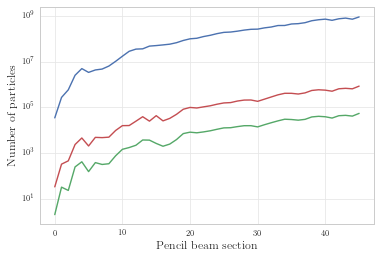

In [56]:
plt.figure(figsize=(6,4))
ax=plt.subplot(111)
ax.plot(particles,label='Particles')
ax.plot(galaxies,label='Galaxies')
ax.plot(halos,label = 'Halos')
# leg = plt.legend(loc='best',frameon=True)
# frame = leg.get_frame()
# frame.set_facecolor('white')
plt.yscale('log')
plt.xlabel('Pencil beam section')
plt.ylabel('Number of particles')
plt.savefig('../../Thesis/Figures/allNumbers.pdf',bbox_inches='tight')